# Image Processor
The goal of this notebook is to create a model that can classify images of the following two classes:
- Kaninchen
- Feldhase

To do so, the following steps are performed:

1. Load the data and apply data augmentation to artificially increase the size of the data set
2. Split the data into training and testing sets
3. Create a model using a feed forward convolutional neural network
4. Configure the model using the adam optimizer and binary crossentropy as the loss function
5. Train the model realizing early stopping and cross validation to prevent overfitting
6. Evaluate the model based on the test data

The comments in this notebook are plenty and generated mostly utilizing the help of artificial intelligence. This approach is chosen, as it enables both the developers and the users of this notebook to better understand the methods and their parameters.

Finally, the contributions are as follows:
- Data Collection: Pauline Neumann, Philip Ritzer
- Worked on the Machine Learning Model: Pauline Neumann, Philip Ritzer, and Tobias Krebs
- Created PowerPoint Presentation: Pauline Neumann

# Imports

In [64]:
import numpy as np
import tensorflow as tf
from keras.src.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split, KFold
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import random

# Implementing data augmentation to artificially increase the size of the data set

In [41]:
# Create an ImageDataGenerator with specified augmentations
datagen = ImageDataGenerator(
    vertical_flip=True,     # Randomly flip images horizontally
    zoom_range=0.2,         # Randomly zoom images (range: 0.2 means 20% zoom in/out)
    shear_range=0.2,        # Randomly shear images
    rotation_range=10,      # Randomly rotate images by up to 10 degrees
    width_shift_range=0.1,  # Randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # Randomly shift images vertically (fraction of total height)
    fill_mode='nearest'     # Fill in missing pixels with the nearest available pixel
)

# Load your dataset using tf.keras.utils.image_dataset_from_directory
data = image_dataset_from_directory('photos')

# Create lists to store augmented images and labels
augmented_images = []
augmented_labels = []

# Loop through each batch of data
for images, labels in data:
    # Loop through each image in the batch
    for i in range(len(images)):
        image_np = images[i].numpy()  # Convert TensorFlow tensor to NumPy array
        augmented_images.append(image_np)  # Original image
        augmented_labels.append(labels[i])

        # Apply data augmentation multiple times (e.g., 3 times)
        for _ in range(4):
            augmented_image = datagen.random_transform(image_np)
            augmented_images.append(augmented_image)
            augmented_labels.append(labels[i])

# Convert lists to NumPy arrays and normalize
augmented_images = np.array(augmented_images) / 255.0
augmented_labels = np.array(augmented_labels)

# Create a new dataset with augmented data
augmented_data = tf.data.Dataset.from_tensor_slices((augmented_images, augmented_labels))

# Shuffle the dataset
augmented_data = augmented_data.shuffle(len(augmented_images))

Found 480 files belonging to 2 classes.


In [42]:
# Calculate the number of images and classes in the dataset
num_images = len(augmented_images)
num_classes = len(np.unique(augmented_labels))

# Print the calculated values
print(f"Number of images: {num_images}")
print(f"Number of classes: {num_classes}")

Number of images: 3360
Number of classes: 2


# Train/Test Split

In [43]:
# test_size=0.2: Specifies that 20% of the data will be used for testing, while 80% will be used for training
# random_state=42: Sets the seed for the random number generator to ensure reproducibility of the split
X_train, X_test, y_train, y_test = train_test_split(augmented_images, augmented_labels, test_size=0.2, random_state=42)

# Create the model

In [44]:
# Define the architecture of the model
model = Sequential([
    Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)),  # Convolutional layer with 16 filters, each of size 3x3, using ReLU activation function. Input shape is 256x256 pixels with 3 channels (RGB).
    MaxPool2D(),  # Max pooling layer to downsample the feature maps.
    Conv2D(32, (3, 3), 1, activation='relu'),
    MaxPool2D(),
    Conv2D(16, (3, 3), 1, activation='relu'),
    MaxPool2D(),
    Flatten(),  # Flatten layer to convert the 2D feature maps into a 1D feature vector.
    Dense(256, activation='relu'),  # Fully connected dense layer with 256 neurons and ReLU activation.
    Dense(1, activation='sigmoid')  # Output layer with 1 neuron and sigmoid activation for binary classification.
])

# Display the summary of the model architecture, including the number of parameters in each layer.
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 62, 62, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 30, 30, 16)       

# Configuring the neural network model

In [45]:
# Compile the model
# the adam optimizer utilizes both an adaptive learning rate and a momentum term. The adaptive learning rate adapts the learning rate of each parameter individually, aiming to minimize the loss function (binary crossentropy in our case). The momentum term accelerates the learning process in the right direction and dampens oscillations
# metrics measure the performance of the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Configure early stopping callback
# patience=3: Specifies the number of epochs with no improvement in validation loss before training is stopped.
# restore_best_weights=True: Specifies that the model weights from the epoch with the lowest validation loss will be restored at the end of training. This ensures that the model retains the best performance observed during training.
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Create cross validation folds + train the model for each fold (with early stopping)

In [46]:
# Define the number of folds for cross-validation
num_folds = 3

# Initialize KFold cross-validation object
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Lists to store metrics for each fold
acc_per_fold = []  # Accuracy for each fold
loss_per_fold = []  # Loss for each fold

# List to store training history for each fold
histories = []

# Initialize fold counter
fold_no = 1

# Iterate over each fold
for train, val in kfold.split(X_train, y_train):
    print(f'Training for fold {fold_no} ...')
    
    # Split data into training and validation sets for the current fold
    X_train_fold, X_val_fold = X_train[train], X_train[val]
    y_train_fold, y_val_fold = y_train[train], y_train[val]
    
    # Fit the model to the training data for the current fold, using early stopping
    history = model.fit(X_train_fold, y_train_fold, validation_data=(X_val_fold, y_val_fold), epochs=20, batch_size=64, callbacks=[early_stopping])
    
    # Save the training history for later plotting
    histories.append(history)
    
    # Increment fold counter
    fold_no += 1

Training for fold 1 ...
Epoch 1/20
28/28 [==============================] - 38s 1s/step - loss: 0.7254 - accuracy: 0.5686 - val_loss: 0.6125 - val_accuracy: 0.6730
Epoch 2/20
28/28 [==============================] - 37s 1s/step - loss: 0.5584 - accuracy: 0.7193 - val_loss: 0.5779 - val_accuracy: 0.7132
Epoch 3/20
28/28 [==============================] - 25s 907ms/step - loss: 0.4725 - accuracy: 0.7751 - val_loss: 0.5627 - val_accuracy: 0.6920
Epoch 4/20
28/28 [==============================] - 32s 1s/step - loss: 0.4282 - accuracy: 0.8097 - val_loss: 0.4371 - val_accuracy: 0.8170
Epoch 5/20
28/28 [==============================] - 31s 1s/step - loss: 0.3293 - accuracy: 0.8471 - val_loss: 0.5226 - val_accuracy: 0.7299
Epoch 6/20
28/28 [==============================] - 30s 1s/step - loss: 0.2907 - accuracy: 0.8817 - val_loss: 0.3731 - val_accuracy: 0.8493
Epoch 7/20
28/28 [==============================] - 28s 1s/step - loss: 0.2009 - accuracy: 0.9252 - val_loss: 0.3203 - val_accuracy: 

In [55]:
# Evaluate the trained model on the test data
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

# Print the test accuracy
print(f'Test accuracy: {test_acc}')

21/21 - 2s - loss: 0.3129 - accuracy: 0.8824 - 2s/epoch - 84ms/step
Test accuracy: 0.882440447807312


# Assess the average performance of the model across all folds

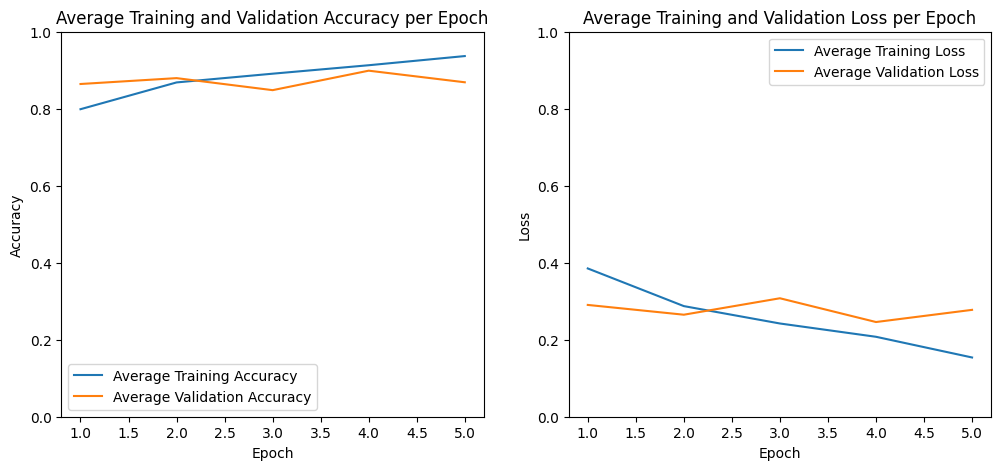

In [59]:
# Find the minimum number of epochs among all folds to enable equal plotting
min_epochs = min([len(history.history['accuracy']) for history in histories])

# Initialize arrays for averaged metrics with the size of the minimum number of epochs
avg_train_acc = np.zeros(min_epochs)
avg_val_acc = np.zeros(min_epochs)
avg_train_loss = np.zeros(min_epochs)
avg_val_loss = np.zeros(min_epochs)

# Sum up the metrics for the minimum epoch range across all folds
for history in histories:
    avg_train_acc += np.array(history.history['accuracy'][:min_epochs])
    avg_val_acc += np.array(history.history['val_accuracy'][:min_epochs])
    avg_train_loss += np.array(history.history['loss'][:min_epochs])
    avg_val_loss += np.array(history.history['val_loss'][:min_epochs])

# Compute the average
# The average is choosen as it provides a more generalized evaluation of the models performance
avg_train_acc /= len(histories)
avg_val_acc /= len(histories)
avg_train_loss /= len(histories)
avg_val_loss /= len(histories)


# Plotting
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(range(1, min_epochs+1), avg_train_acc, label='Average Training Accuracy')
plt.plot(range(1, min_epochs+1), avg_val_acc, label='Average Validation Accuracy')
plt.title('Average Training and Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(range(1, min_epochs+1), avg_train_loss, label='Average Training Loss')
plt.plot(range(1, min_epochs+1), avg_val_loss, label='Average Validation Loss')
plt.title('Average Training and Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.legend()

plt.show()

# Assess the average performance of the model across for each fold

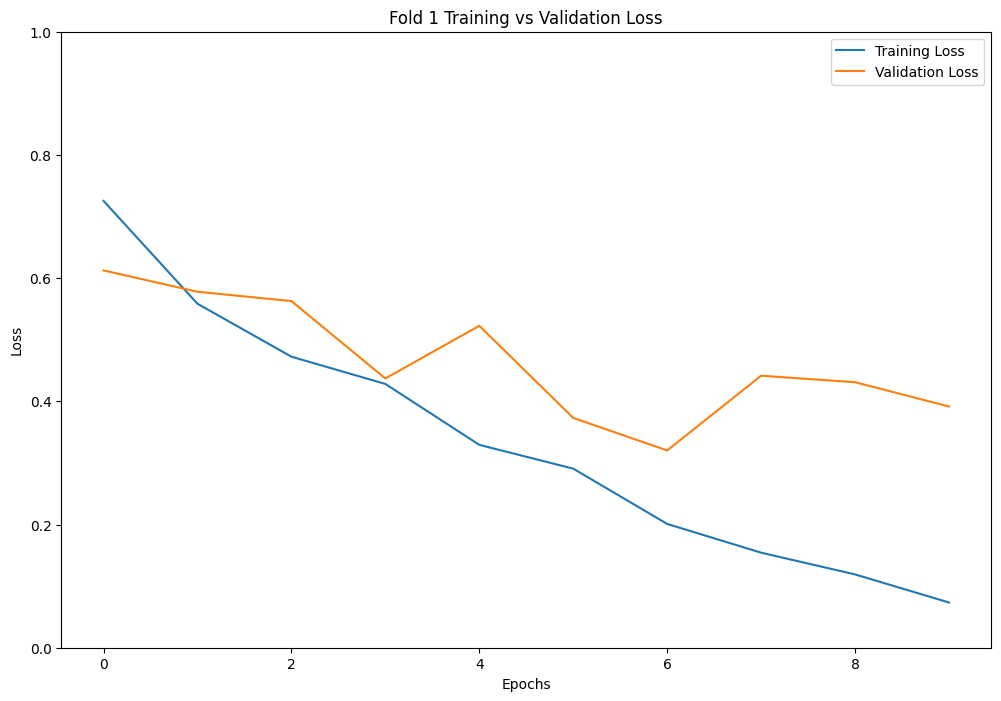

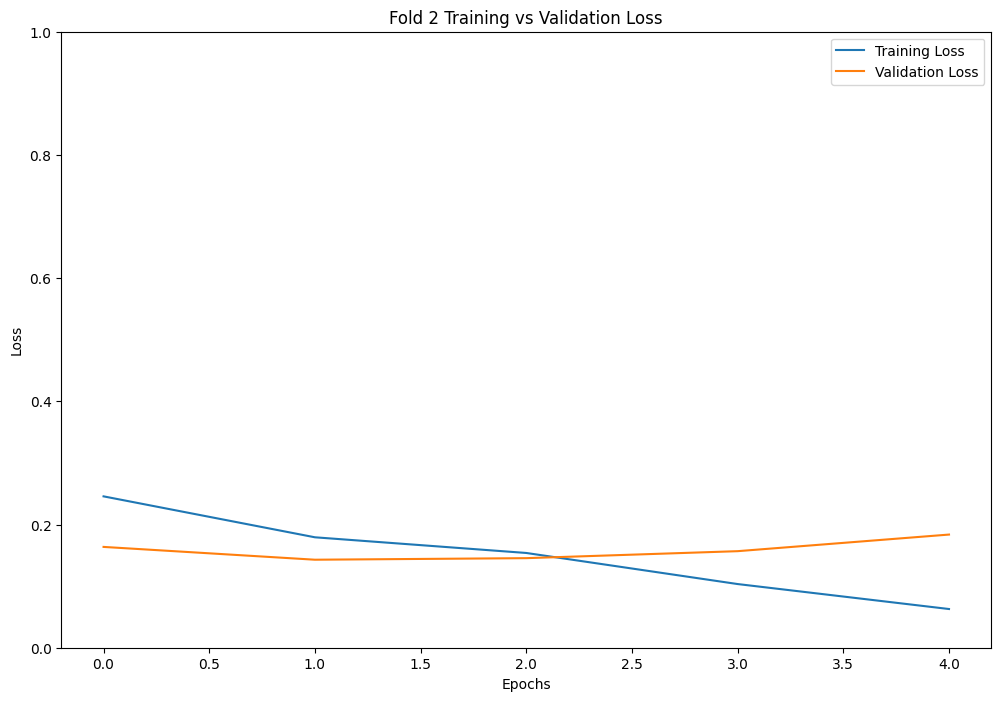

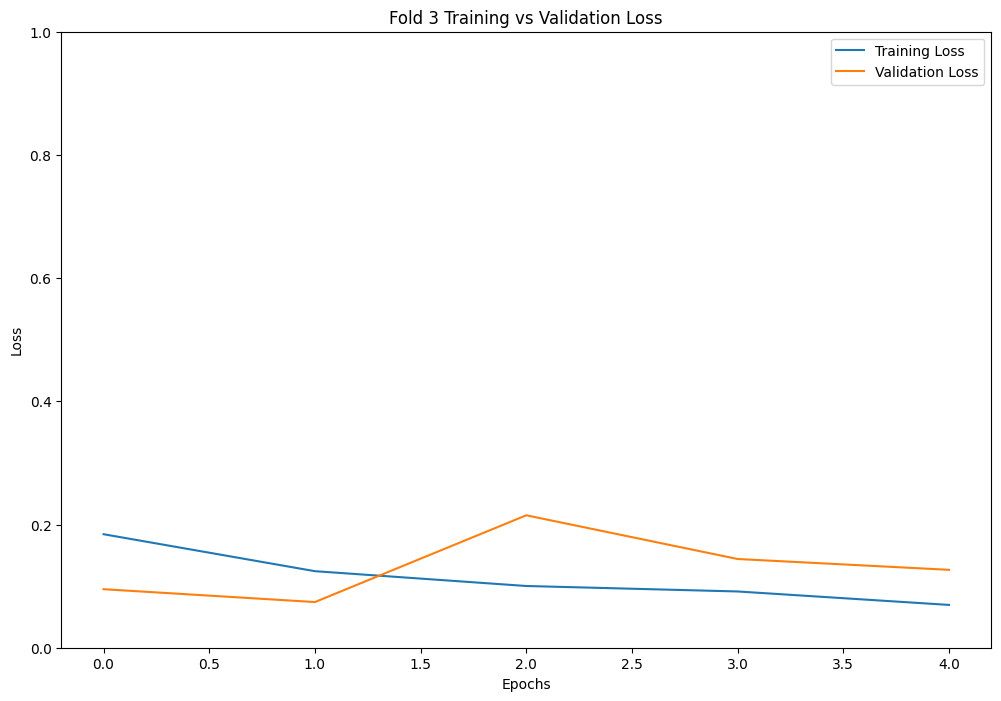

In [58]:
for i, history in enumerate(histories):
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {i+1} Training vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

# Save the model

In [ ]:
model.save("classification_model")

# Load a model

In [ ]:
# Load the model
model = load_model('classification_model')

# Load random image (Feldhase or Kaninchen) and predict its class

1/1 [==============================] - 0s 27ms/step


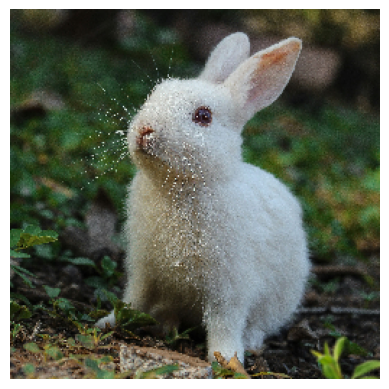

Predicted class: Kaninchen (0.9991422891616821)
Filename: kaninchen_0.jpg


In [75]:
# List all test images
test_images_dir = 'test_images'
test_images = os.listdir(test_images_dir)

# Select a random image path
random_image = random.choice(test_images)

# Full path to the randomly selected image
image_path = os.path.join(test_images_dir, random_image)

# Load and preprocess the image
img = load_img(image_path, target_size=(256, 256))
img_array = img_to_array(img)                                   # Convert the image to a numpy array
img_array_rescaled = img_array / 255.0                          # Scale the image
img_array_expanded = np.expand_dims(img_array_rescaled, axis=0) # expand_dims adds a dimension to the array to make it compatible with the model which expects a batch of images

# Predict with the model
predictions = model.predict(img_array_expanded)

# Assuming a binary classification (class1 or class2)
predicted_class = 'Feldhase' if predictions[0][0] < 0.5 else 'Kaninchen'

# Display the image and prediction
plt.imshow(img_array_rescaled)
plt.axis('off')
plt.show()

print(f'Predicted class: {predicted_class} ({predictions[0][0]})')
print(f'Filename: {random_image}')